Here we use value function iteration to solve the infinite horizon stochastic consumption-savings problem

The problem is 

$$v\left(a,y\right)= \max_{c,a'}u\left(c\right)+ \beta  \mathbb{E} \left[v \left(a',y'\right) \mid y \right]$$
subject to 

$$ c=y+\left(1+r\right)a-a'$$

and 
$$a'   \geq \underline{a} $$

Income is a Markov chain with matrix $P$.


In [127]:
using Plots 
using Parameters
include("markov_utils.jl")
using .Markov, LinearAlgebra, Statistics, Distributions, Printf, Random

In [140]:
Household = @with_kw (r = 0.01,                 
                      σ = 2.0,
                      β = 0.98,
                      y = [0.8 1.2],
                      P = [0.7 0.3; 0.3 0.7],
                      a0 = 0.0,
                      u = σ == 1 ? x -> log(x) : x -> (x^(1 - σ) - 1) / (1 - σ)
					  )

##NamedTuple_kw#389 (generic function with 2 methods)

In [141]:
hh   = Household()


@assert size(hh.P)[1] == size(hh.P)[2] # check stochastic matrix: square required
@assert sum(hh.P,dims=2) == ones(size(hh.P)[1],1) # rows sum to 1


In [142]:
sum(hh.P,dims=2)
ones(size(hh.P)[1])

2-element Vector{Float64}:
 1.0
 1.0

In [143]:
function asset_grid(;N=120,a_min=0.0,a_max=2.0)
    # this function creates a grid
    a_grid = collect(range(a_min, stop = a_max, length = N))
    return a_grid
    end
    
    a_grid=asset_grid();

In [144]:
function vfi_infinite(hh, a_grid; ϵ = 1e-6, maxiter = 300)
y_grid = hh.y
P      = hh.P
# this is the key function here, it solves the consumption-savings problem
N_a      = length(a_grid);
N_y      = length(y_grid);
V      = Matrix{Float64}(undef, N_a, N_y);
V_old  = Matrix{Float64}(undef, N_a, N_y);
a′     = Matrix{Float64}(undef, N_a, N_y);
a′_ind = Matrix{Int}(undef, N_a, N_y);
c      = Matrix{Float64}(undef, N_a, N_y);
w_temp = Matrix{Float64}(undef, N_a, 1);
u_temp = Matrix{Float64}(undef, N_a, 1);
c_temp = Matrix{Float64}(undef, N_a, 1);



# guess something initial
V_old    .= 0.0
err      = 10.0

# start iteration
for n in 1:maxiter
    

    # for each possible realization of income today...
    for iy in eachindex(y_grid)
        # for each asset grid point today...

        for ia in eachindex(a_grid)

            #... consider each possible asset grid point tomorrow
            for ia′ in eachindex(a_grid)

                #... calculate what would be consumption today

                if (1+hh.r) * a_grid[ia] + y_grid[iy] - a_grid[ia′] < 1e-10
                    c_temp[ia′] = 1e-10  # if consumption is negative, set to a very small number
                    u_temp[ia′] = -Inf  # calculate utility
                else
                    c_temp[ia′] = (1+hh.r) * a_grid[ia] + y_grid[iy] - a_grid[ia′]
                    u_temp[ia′] = hh.u(c_temp[ia′])  # calculate utility
                end

                #... utility  calculate expected continuation value 

                w_temp[ia′] = u_temp[ia′] + hh.β * sum(P[iy,:] .* V_old[ia′,:])  # calulate utility + EXPECTED continuation value
                
            end

            V[ia,iy], ia′_opt  = findmax(w_temp[:])  # find optimum - stores Value und policy (index of optimal choice)
            a′[ia,iy]            = a_grid[ia′_opt]    # record optimal assets tomorrow
            a′_ind[ia,iy]        = ia′_opt
            
        end
    end


    err,z = findmax(abs.(V .- V_old));

    if err < ϵ
        break
    end

    V_old .= V 

end
c = (1+hh.r) * a_grid .+ y_grid - a′
return V, a′, a′_ind, c, err
end


vfi_infinite (generic function with 1 method)

In [145]:
# solve the problem for our household
V, a′, a′_ind, c, err = vfi_infinite(hh, a_grid)

([-1.143816920842923 -0.3712906950252633; -1.1178455757997883 -0.3536937206530528; … ; 0.8585655465254027 1.379797154357287; 0.8726511276316817 1.3913627991248059], [0.0 0.2184873949579832; 0.0 0.23529411764705882; … ; 1.6974789915966386 2.0; 1.7142857142857142 2.0], [1 14; 1 15; … ; 102 120; 103 120], [0.8 0.9815126050420168; 0.8169747899159664 0.9816806722689075; … ; 1.105546218487395 1.203025210084034; 1.105714285714286 1.2199999999999998], 9.871348631840249e-7)

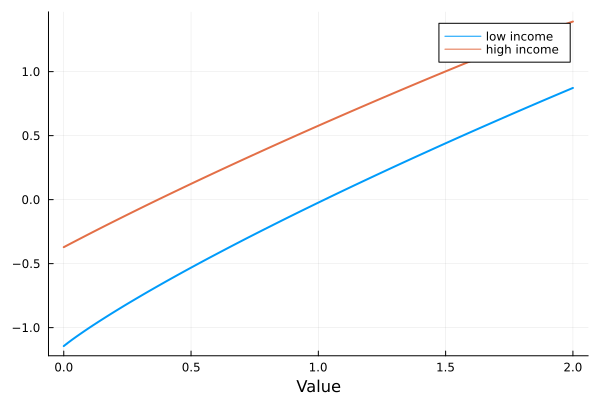

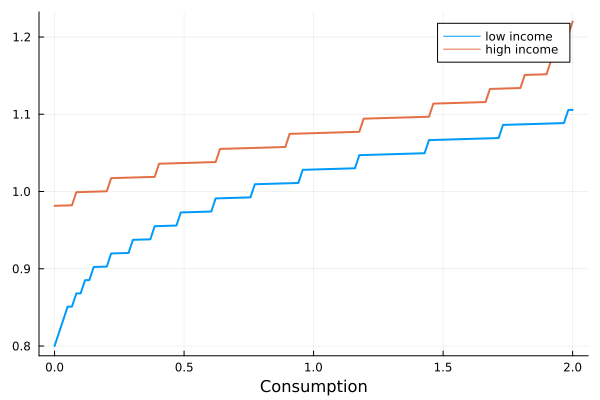

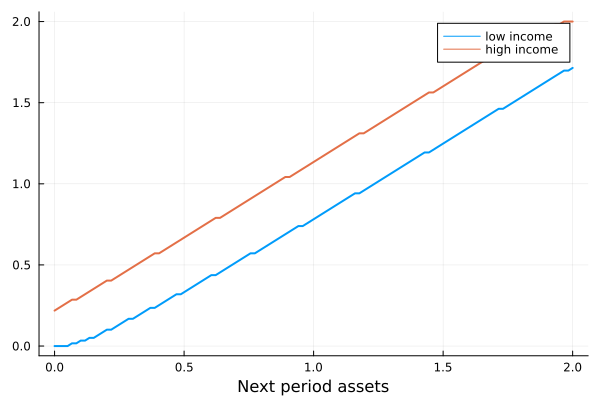

In [146]:

# plot the solution
value_plot        = plot(xlabel = "Value") 
plot!(value_plot, a_grid,  V, labels=["low income" "high income"], lw = 2)

consumption_plot   = plot(xlabel = "Consumption")
plot!(consumption_plot, a_grid,  c, labels=["low income" "high income"], lw = 2)

next_assets_plot       = plot(xlabel = "Next period assets")
plot!(next_assets_plot, a_grid,  a′, labels=["low income" "high income"], lw = 2)

display(value_plot)
display(consumption_plot)
display(next_assets_plot)

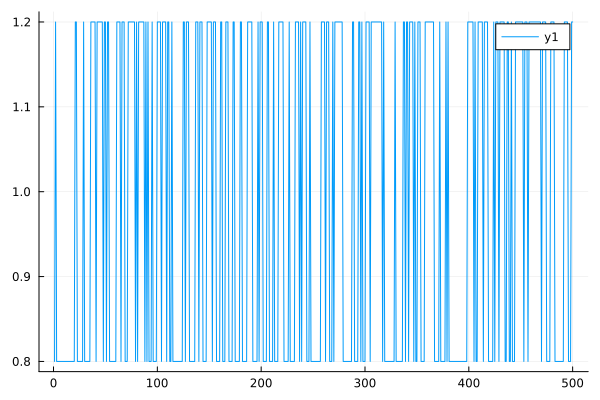

In [147]:
T =500
mc_realized = mc_sample_path(hh.P; init = 1, sample_size = T)
y_path = hh.y[mc_realized];
plot(y_path)

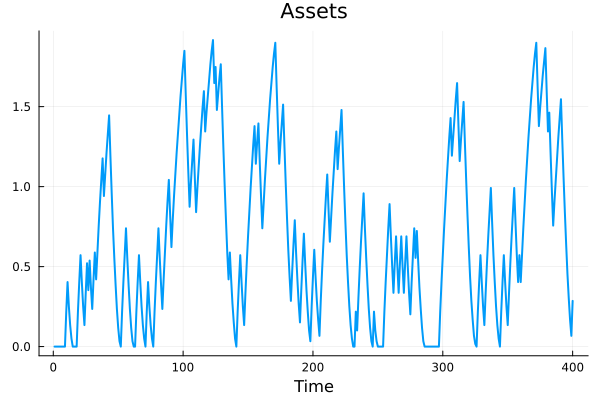

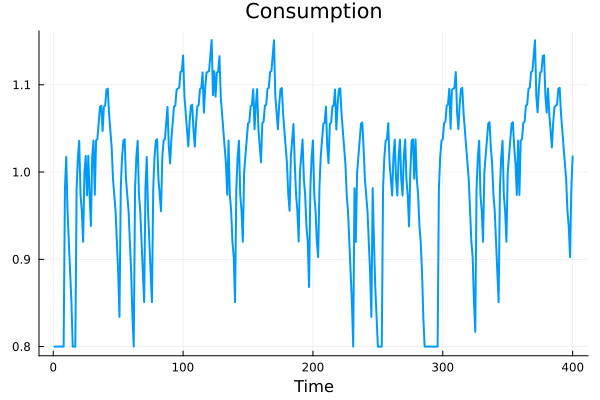

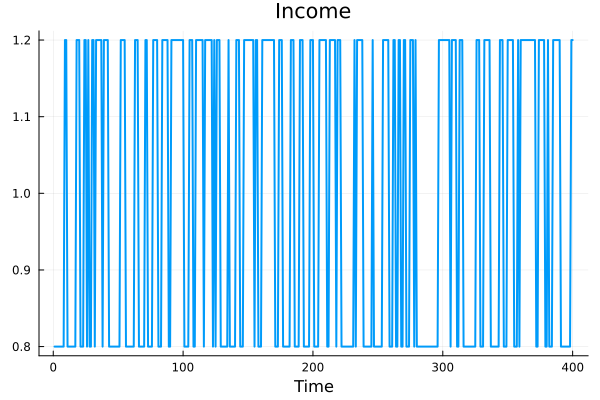

In [148]:

function get_paths(a_grid,hh,a′,a′_ind,T)
# this function find the optimal paths
findnearest(A,x) = argmin(abs.(A .- x))

ia′ = findnearest(a_grid,hh.a0)
a_path = Array{Float64}(undef,T)
a′_path = Array{Float64}(undef,T)
c_path = Array{Float64}(undef,T)

mc_realized = mc_sample_path(hh.P; init = 1, sample_size = T)
y_path = hh.y[mc_realized];

for t = 1:T 
   iy         = mc_realized[t]
   ia         = ia′
   a_path[t]  = a_grid[ia] 
   a′_path[t] = a′[ia,iy]  
   c_path[t]  = c[ia,iy]  
   ia′        = a′_ind[ia,iy]
end

return a_path, a′_path, y_path, c_path
end


# get those paths and plot them
T = 400
a_path, a′_path, y_path, c_path = get_paths(a_grid,hh,a′,a′_ind,T)
a_path_plot = plot(1:T,a_path,label=false, lw = 2, title = "Assets", xlabel = "Time")
c_path_plot = plot(1:T,c_path,label=false, lw = 2, title = "Consumption", xlabel = "Time")
y_path_plot = plot(1:T,y_path,label=false, lw = 2, title = "Income", xlabel = "Time")

display(plot(a_path_plot))
display(plot(c_path_plot))
display(plot(y_path_plot))


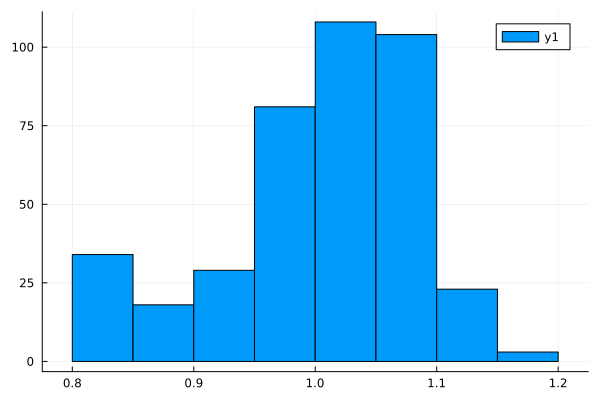

In [165]:
histogram(c_path)
